In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from pyascore import SpectraParser, IdentificationParser, PyAscore

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Evaluation of pyAscore's scoring time per PSM

## 1) Intro

For both large scale file processing and real time processing of single spectra, it is important for pyAscore to be as efficient as possible. Here, we will evaluate pyAscore's scoring time per scan and see whether it is fast enough to be broadly usable across scoring applications

## 2) Load PSMs to score

PSMs are loaded from mokapot results, which allows us to both widdle down to the most relevant hits and have a dataframe to store results as scoring occurs.

In [2]:
psms = pd.read_csv("../results/search/PXD007740/PXD007740.mokapot.psms.txt", sep="\t")
psms = psms.rename({"ScanNr" : "scan"}, axis=1)
psms["replicate"] = psms["SpecId"].str.extract("(R[1-3])")
psms["nphospho"] = psms["Peptide"].str.count("79.9663")
psms["nacceptors"] = psms["Peptide"].str.count("[STY]")
psms["nperm"] = psms.apply(lambda s: comb(s["nacceptors"], s["nphospho"]), axis=1).astype(int)

# Filter for passing phosphopeptides
psms = psms[psms["mokapot q-value"] < 0.01]
psms = psms[psms["nphospho"].isin([1, 2, 3])]

# Select final columns
psms = psms[["replicate", "scan", "nphospho", "nacceptors", "nperm"]].copy()

## 3) Score with pyAscore

While we will iterate through the Mokapot PSMs, the actual information will be extracted from individual scoring files using the internal parser classes. This serves as a simple test bed for the classes and an example of how they can be used to get the relevant information from spectra with relative ease.

In [3]:
%%time
psm_objects = {}
for rep in ["R1", "R2", "R3"]:
    id_parser = IdentificationParser("../results/search/PXD007740/PXD007740.ctr_2h_{}_IMAC_1.pep.xml".format(rep),
                                     "pepXML")
    psm_objects.update(
        {(rep, psm["scan"]) : psm
         for psm in id_parser.to_list()}
    )

CPU times: user 11.9 s, sys: 1.9 s, total: 13.8 s
Wall time: 39.7 s


In [4]:
%%time
spectra_objects = {}
for rep in ["R1", "R2", "R3"]:
    spectra_parser = SpectraParser("../results/samples/PXD007740/PXD007740.ctr_2h_{}_IMAC_1.mzML".format(rep),
                                   "mzML")
    spectra_objects.update(
        {(rep, spectra["scan"]) : spectra 
         for spectra in spectra_parser.to_list()}
    )

CPU times: user 10.1 s, sys: 2.88 s, total: 13 s
Wall time: 54.6 s


In [5]:
%%time
mod_mass = 79.966331
ascore = PyAscore(bin_size=100., n_top=10,
                  mod_group="STY",
                  mod_mass=mod_mass,
                  mz_error=.02)

psms["pyascore_times"] = 0.
psms["sequence"] = ""
psms["pepscore"] = 0.
psms["ascores"] = 0.
psms["charge"] = 0

for ind in range(psms.shape[0]):
    # Get PSM info
    rep = psms["replicate"].values[ind]
    scan = psms["scan"].values[ind]
    spectra = spectra_objects[(rep, scan)]
    psm = psm_objects[(rep, scan)]
    
    # Process modifications
    mod_select = np.isclose(psm["mod_masses"], mod_mass)
    n_mods = np.sum(mod_select)
    aux_mod_pos = psm["mod_positions"][~mod_select].astype(np.uint32)
    aux_mod_masses = psm["mod_masses"][~mod_select].astype(np.float32)
    
    # Time scoring
    t0 = time.time()
    ascore.score(spectra["mz_values"],
                 spectra["intensity_values"],
                 psm["peptide"],
                 np.sum(mod_select),
                 psm["charge_state"] - 1,
                 aux_mod_pos,
                 aux_mod_masses)
    psms["pyascore_times"].values[ind] = time.time() - t0
    psms["sequence"].values[ind] = ascore.best_sequence
    psms["pepscore"].values[ind] = ascore.best_score
    psms["ascores"].values[ind] = ascore.ascores[0]
    psms["charge"].values[ind] = psm["charge_state"]
    
psms["log_pyascore_times"] = np.log10(psms["pyascore_times"])

CPU times: user 5.99 s, sys: 2.47 ms, total: 5.99 s
Wall time: 6.01 s


Proportion of scores below 1ms: 0.9971
Median scoring time per replicate:
replicate
R1    0.000073
R2    0.000062
R3    0.000073
Name: pyascore_times, dtype: float64


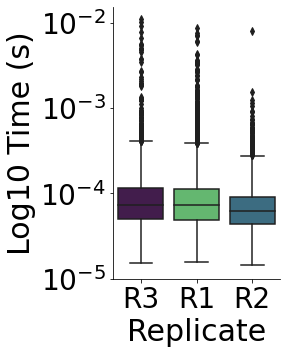

In [6]:
fig = plt.figure(figsize=(3, 5))

print("Proportion of scores below 1ms: {:.4f}".format(
          np.sum(psms["pyascore_times"] < 0.001)/psms.shape[0]
     )
)

print("Median scoring time per replicate:")
print(psms.groupby("replicate").pyascore_times.median())

sns.boxplot(data=psms,
            x="replicate",
            y="log_pyascore_times",
            palette=["#461554", "#56c566", "#30708d"])

plt.yticks([-5, -4, -3, -2],
           ["$10^{-5}$", "$10^{-4}$",
            "$10^{-3}$", "$10^{-2}$"])
plt.tick_params(labelsize=28)
plt.xlabel("Replicate", size=30)
plt.ylabel("Log10 Time (s)", size=30)
sns.despine()
plt.savefig("figures/pyascore_scoring_speed_boxplot.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

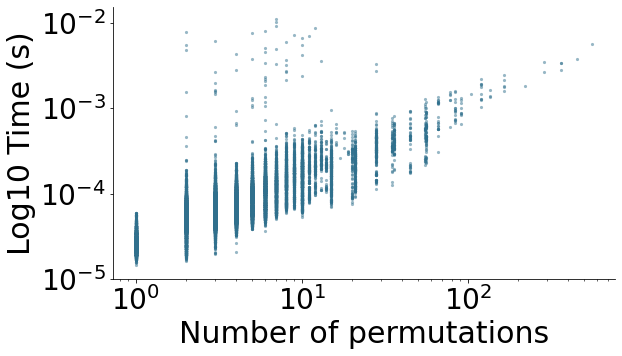

In [12]:
fig = plt.figure(figsize=(9, 5))

sns.scatterplot(data=psms,
                x="nperm",
                y="log_pyascore_times",
                color="#30708d",
                linewidth=0,
                alpha=.5,
                s=10)

plt.yticks([-5, -4, -3, -2],
           ["$10^{-5}$", "$10^{-4}$",
            "$10^{-3}$", "$10^{-2}$"])
plt.xscale("log")
plt.tick_params(labelsize=28)
plt.xlabel("Number of permutations", size=30)
plt.ylabel("Log10 Time (s)", size=30)

sns.despine()
plt.savefig("figures/pyascore_scoring_speed_scatter.svg",
            bbox_inches="tight",
            facecolor="white")
plt.savefig("figures/pyascore_scoring_speed_scatter.png",
            dpi=600,
            bbox_inches="tight",
            facecolor="white")
plt.show()

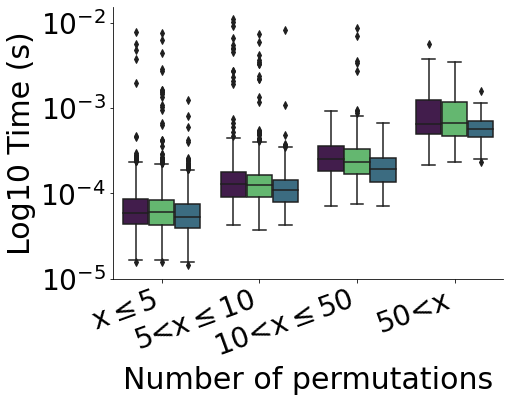

In [13]:
fig = plt.figure(figsize=(7, 5))

psms["nperm_cut"] = pd.cut(psms.nperm, bins=[0, 5, 10, 50, 1000])

sns.boxplot(data=psms,
            x="nperm_cut",
            y="log_pyascore_times",
            hue="replicate",
            palette=["#461554", "#56c566", "#30708d"])

plt.yticks([-5, -4, -3, -2],
           ["$10^{-5}$", "$10^{-4}$",
            "$10^{-3}$", "$10^{-2}$"])
plt.xticks([0, 1, 2, 3], ["x$\leq$5", "5<x$\leq$10", "10<x$\leq$50", "50<x"],
           rotation=20, ha="right")
plt.tick_params(labelsize=28)
plt.xlabel("Number of permutations", size=30)
plt.ylabel("Log10 Time (s)", size=30)
plt.legend().remove()
sns.despine()
plt.savefig("figures/pyascore_scoring_speed_boxscatter.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The linearly increasing trend on the log-log plot above is exactly what we would expect. The most computationally intensive part of the algorithm is definitely the iteration over every single permutation of modified and unmodified sites and producing a score. This said, the overall low scoring time bodes well for the algorithm, and is one reason that scoring tends to only take a few seconds for a single MS file. Most computational time in fact is devoted to reading in a preprocessing the data.